In [8]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv("/content/drive/My Drive/DataSet/Housing.csv",sep=",")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [11]:
df["furnishingstatus"].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [0]:
## basement,hotwareheating,Airconditioning is just nominal categorical ,guestRoom,Not A RANKING,Right?
## So we are going to turn this to Dummies 
df["mainroad"].replace({"yes" :1 , "no" : 0},inplace=True)
df["guestroom"].replace({"yes" :1 , "no" : 0},inplace=True)
df["basement"].replace({'yes' : 1, "no" : 0 },inplace=True)
df["hotwaterheating"].replace({"yes":1 , "no":0},inplace=True)
df["airconditioning"].replace({"yes":1 , "no":0},inplace=True)
df["prefarea"].replace({"yes":1 , "no" :0},inplace=True)
df["furnishingstatus"].replace({"furnished":2 , "semi-furnished":1, "unfurnished":0},inplace=True)
df["TotalRooms"] = df["bedrooms"].astype(int) + df["bathrooms"].astype(int) +df["guestroom"].astype(int) + df["basement"].astype(int)
df["HasParking"] = np.where(df["parking"] > 1 ,1,0)
df["LotBed"] = np.where(df["bedrooms"] >= 4,1,0)
df["LotBathrooms"] = np.where(df["bathrooms"] >= 3 ,1,0)

In [0]:
x_features = df.drop(["bedrooms","bathrooms",'guestroom',"basement","TotalRooms","mainroad","parking"],axis=1)
target = np.log(df['price'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_features.values, i) for i in range(x_features.shape[1])]
vif["features"] = x_features.columns



In [0]:
#x_features = df.drop("price",axis=1)


In [0]:
## Check The Type of Problems 
#sns.pairplot(df)

In [16]:
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
df[x_features.columns] = df[x_features.columns].apply(normalize) 
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,TotalRooms,HasParking,LotBed,LotBathrooms
0,1.000000,0.396564,4,2,0.666667,1,0,0,0.0,1.0,2,1.0,1.0,6,1.0,1.0,0.0
1,0.909091,0.502405,4,4,1.000000,1,0,0,0.0,1.0,3,0.0,1.0,8,1.0,1.0,1.0
2,0.909091,0.571134,3,2,0.333333,1,0,1,0.0,0.0,2,1.0,0.5,6,1.0,0.0,0.0
3,0.906061,0.402062,4,2,0.333333,1,0,1,0.0,1.0,3,1.0,1.0,7,1.0,1.0,0.0
4,0.836364,0.396564,4,1,0.333333,1,1,1,0.0,1.0,2,0.0,1.0,7,1.0,1.0,0.0


In [0]:
from sklearn.model_selection import GridSearchCV , KFold ,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



# hyperparams = {
#                "min_samples_split" : np.arange(1,20,2),
#                "min_samples_leaf" :[1,3,5],
#                "max_depth" : np.arange(1,15,1)}
kfold = KFold(n_splits=8,shuffle=True,random_state=42)
# Model = GridSearchCV(RandomForestRegressor(random_state=42),
#                      param_grid = hyperparams,
#                      verbose = True,
#                      cv = kfold,
#                      n_jobs = -1)

# Model.fit(x_features,target)


In [18]:
import statsmodels.api as sm
x = sm.add_constant(x_features)
linearreg = sm.OLS(target,x).fit()
print(linearreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     903.0
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:32   Log-Likelihood:                 552.14
No. Observations:                 545   AIC:                            -1082.
Df Residuals:                     534   BIC:                            -1035.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.3587      0.013  

Well this is not really linear problem ,seems it's more likely Non Linear Problems

In [19]:
from sklearn.linear_model import ElasticNet
alpha = {"alpha":np.arange(0.01,5,0.01)}
Model_Elastic = GridSearchCV(ElasticNet(),param_grid=alpha,
                             cv=kfold,
                             verbose=True,
                             n_jobs=-1)
Model_Elastic.fit(x_features,target)


Fitting 8 folds for each of 499 candidates, totalling 3992 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3992 out of 3992 | elapsed:   13.1s finished


GridSearchCV(cv=KFold(n_splits=8, random_state=42, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([0.01, 0.02, 0.03...
       4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5 , 4.51,
       4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62,
       4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7 , 4.71, 4.72, 4.73,
       4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.8 , 4.81, 4.82, 4.83, 4.84,
       4.85, 4.86, 4.87, 4.88, 4.89, 4.9 , 4.91, 4.92, 4.93, 4.94, 4.95,
       4.96, 4.97, 4.98, 4.99])},
             pre_dispatch='2*n_jobs', 

In [20]:
Model_Elastic.best_score_

0.9414426985744095

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x_features,target,test_size=0.2)
Model_ela = ElasticNet(alpha=0.01)
Model_ela.fit(x_train,y_train)
y_pred = Model_ela.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
mse(y_test,y_pred)

0.01039957771463529

In [22]:
from sklearn.linear_model import LinearRegression
Model_linear = LinearRegression()
Model_linear.fit(x_train,y_train)
y_pred = Model_linear.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
mse(y_test,y_pred)

0.010610520036436252

In [23]:
rf = RandomForestRegressor(n_estimators=100,max_depth = 12 , min_samples_leaf = 1, min_samples_split = 15)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
mse(y_test,y_pred)

0.0008251762255372632

In [0]:
# np.sqrt(mse(y_test,y_pred))
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(x_features.values, i) for i in range(x_features.shape[1])]
# vif["features"] = x_features.columns
# vif

0.06272947365594705


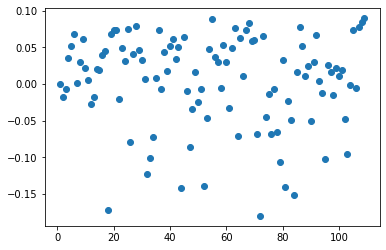

In [25]:
# x_features = df.drop(["bedrooms","bathrooms",'guestroom',"basement","TotalRooms","mainroad","parking"],axis=1)
# target = df['price']

x_train,x_test,y_train,y_test = train_test_split(x_features,target,test_size=0.2)
Model_ela = ElasticNet(alpha=0.01)
Model_ela.fit(x_train,y_train)
y_pred = Model_ela.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(y_test,y_pred)))
c = [i for i in range(1,110,1)]
plt.scatter(c,y_test - y_pred)

0.010534747740436234


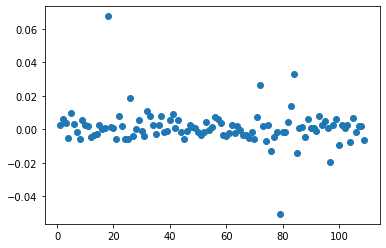

In [26]:
rf = RandomForestRegressor(n_estimators=100,max_depth = 12 , min_samples_leaf = 1, min_samples_split = 15)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(y_test,y_pred)))
c = [i for i in range(1,110,1)]
plt.scatter(c,y_test - y_pred)

In [27]:
from sklearn.linear_model import LinearRegression
Model_linear = LinearRegression()
Model_linear.fit(x_train,y_train)
y_pred = Model_linear.predict(x_test)
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(y_test,y_pred))

0.06101123385188067

0.06101123385188067

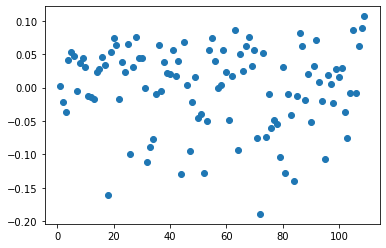

In [28]:
c = [i for i in range(1,110,1)]
plt.scatter(c,y_test - y_pred)
np.sqrt(mse(y_test,y_pred))